In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from bayes_opt import BayesianOptimization

In [2]:

class TweetClassificationModel:
    def __init__(self, data_file):
        # Load the dataset
        self.df = pd.read_csv(data_file)
        self.df = self.df.drop_duplicates('Tweet', keep='first')
        self.df["Cleaned_Tweet"] = [re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", "", v.lower()) for v in self.df["Tweet"]]
        self.df.drop('Tweet', axis=1, inplace=True)
        vals_to_replace = {'Relevant': 1, 'Not Relevant': 0}
        self.df['Category'] = self.df['Category'].map(vals_to_replace)
        self.df.dropna(inplace=True)
        self.df['Category'].unique()

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df['Cleaned_Tweet'], self.df['Category'], test_size=0.2, random_state=42)

        # Initialize Tokenizer
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.X_train)
        self.max_sequence_length = 100

    def preprocess_data(self):
        # Tokenize and pad the sequences
        X_train_sequences = self.tokenizer.texts_to_sequences(self.X_train)
        X_test_sequences = self.tokenizer.texts_to_sequences(self.X_test)
        self.X_train_padded = pad_sequences(X_train_sequences, maxlen=self.max_sequence_length)
        self.X_test_padded = pad_sequences(X_test_sequences, maxlen=self.max_sequence_length)

    def build_model(self, optimizer):
        # Build the LSTM model
        self.model = Sequential()
        self.model.add(Embedding(len(self.tokenizer.word_index) + 1, 32, input_length=self.max_sequence_length))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(LSTM(64))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def train_model(self, epochs=5, batch_size=32):
        # Train the LSTM model
        history = self.model.fit(self.X_train_padded, self.y_train, validation_data=(self.X_test_padded, self.y_test), epochs=epochs, batch_size=batch_size)
        return history

    def evaluate_model(self):
        # Evaluate the model on the test set
        y_pred = self.model.predict(self.X_test_padded)
        auc = roc_auc_score(self.y_test, y_pred)
        print("AUC:", auc)
        return y_pred  # Return y_pred for later use in plot_roc_curve

    def plot_roc_curve(self, y_pred):
        # Plot the ROC curve
        auc = roc_auc_score(self.y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(loc="lower right")
        plt.show()

    def plot_learning_curves(self, history):
        # Plot the learning curves
        plt.figure()
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def bayesian_optimization(self):
        # Define the hyperparameter search space
        pbounds = {
            'learning_rate': (1e-5, 1e-2),
            'dropout_rate': (0.1, 0.5),
            'lstm_units': (32, 128)
        }

        def evaluate_model(learning_rate, dropout_rate, lstm_units):
            # Build the model with the given hyperparameters
            optimizer = Adam(learning_rate=learning_rate)
            self.build_model(optimizer)
            # Train the model with the current hyperparameters
            history = self.train_model(epochs=5, batch_size=32)
            # Return the validation accuracy as the objective to maximize
            return history.history['val_accuracy'][-1]

        # Initialize Bayesian Optimization
        optimizer = BayesianOptimization(
            f=evaluate_model,
            pbounds=pbounds,
            verbose=2,  # Set verbose=2 to see the optimization process
            random_state=42
        )
        # Perform optimization
        optimizer.maximize(init_points=5, n_iter=10)

        # Get the best hyperparameters
        best_hyperparams = optimizer.max['params']
        print("Best Hyperparameters:")
        print(best_hyperparams)

        # Train the model with the best hyperparameters
        optimizer = Adam(learning_rate=best_hyperparams['learning_rate'])
        self.build_model(optimizer)
        history = self.train_model(epochs=50, batch_size=32)

        # Evaluate and plot ROC curve with the best model
        y_pred = self.evaluate_model()
        self.plot_roc_curve(y_pred)

        # Plot learning curves of the best model
        self.plot_learning_curves(history)

|   iter    |  target   | dropou... | learni... | lstm_u... |
-------------------------------------------------------------
Epoch 1/5
254/254 [==============================] - 13s 42ms/step - loss: 0.5143 - accuracy: 0.7542 - val_loss: 0.4605 - val_accuracy: 0.8158
Epoch 2/5
254/254 [==============================] - 10s 39ms/step - loss: 0.2801 - accuracy: 0.8928 - val_loss: 0.4922 - val_accuracy: 0.7970
Epoch 3/5
254/254 [==============================] - 10s 40ms/step - loss: 0.1588 - accuracy: 0.9399 - val_loss: 0.6044 - val_accuracy: 0.7832
Epoch 4/5
254/254 [==============================] - 10s 38ms/step - loss: 0.0873 - accuracy: 0.9642 - val_loss: 0.8481 - val_accuracy: 0.7852
Epoch 5/5
254/254 [==============================] - 10s 40ms/step - loss: 0.0612 - accuracy: 0.9749 - val_loss: 1.0128 - val_accuracy: 0.7748
| 1         | 0.7748    | 0.2498    | 0.009508  | 102.3     |
Epoch 1/5
254/254 [==============================] - 13s 42ms/step - loss: 0.5157 - accuracy: 0.750

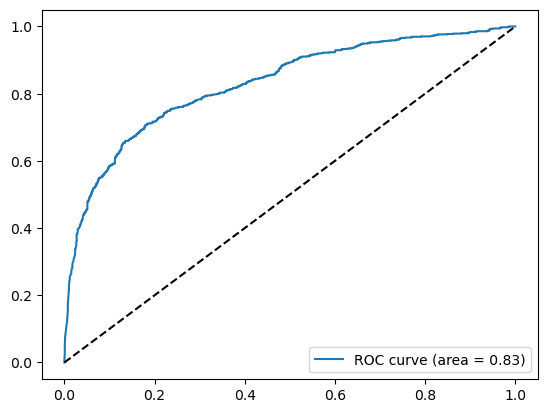

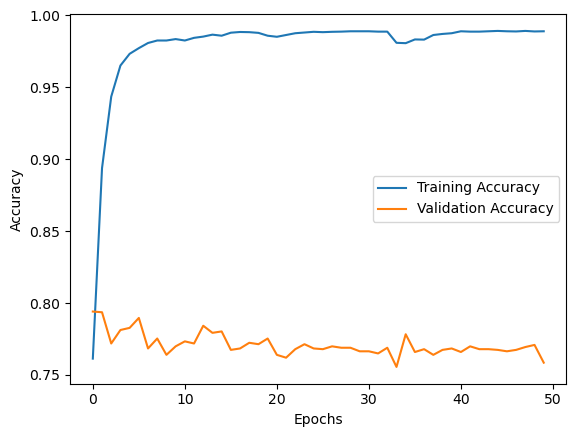

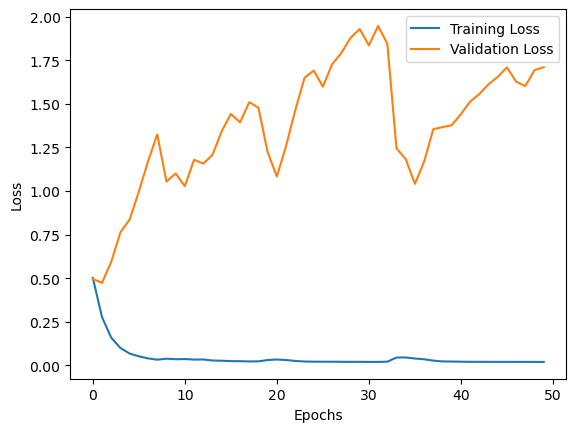

In [3]:
data_file = "D:/study/group3.csv"
model = TweetClassificationModel(data_file)
model.preprocess_data()
model.bayesian_optimization()